#Human Face detection SVM
Fateme Ranjbaran 400126060

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
# Importing necessary libraries


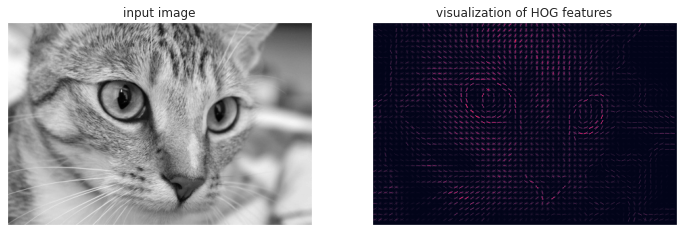

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');


In [3]:
from PIL import Image
import numpy as np

im = np.array(Image.open('/content/images.jfif'))

print(type(im))
image1 = color.rgb2gray(im)

<class 'numpy.ndarray'>


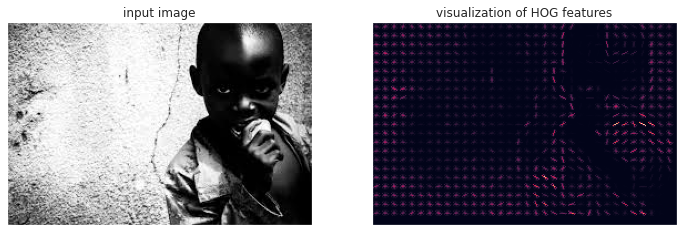

In [ ]:
from skimage import data, color, feature
# import skimage.data
import cv2

hog_vec, hog_vis = feature.hog(image1, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [5]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape


(13233, 62, 47)

In [6]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

<ipython-input-6-4ff79985fbcb>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


In [ ]:
from sklearn.feature_extraction.image import PatchExtractor

# Defining function: extract_patches

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

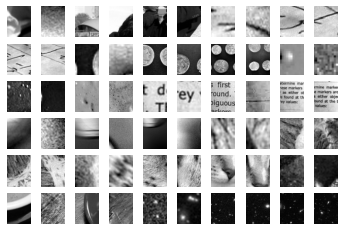

In [8]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [9]:
from itertools import chain
X = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y = np.zeros(X.shape[0])
y[:positive_patches.shape[0]] = 1


In [10]:
X.shape
y.shape

(43233,)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.96805435, 0.97368802, 0.9722423 , 0.97441087, 0.97151944])

In [78]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

0.9933210587704883

In [79]:
grid.best_params_

{'C': 1.0}

In [80]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [39]:
from PIL import Image
import numpy as np

im_test = np.array(Image.open('/content/lao13099bk_nb_03_i.webp'))

print(type(im))
im_test= color.rgb2gray(im_test)

<class 'numpy.ndarray'>


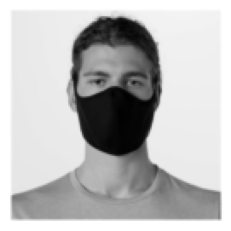

In [40]:

im_test = skimage.transform.rescale(im_test, 0.08)


plt.imshow(im_test, cmap='gray')
plt.axis('off');


In [41]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(im_test))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1089, 1215)

In [19]:
labels = model.predict(patches_hog)
labels.sum()

41.0

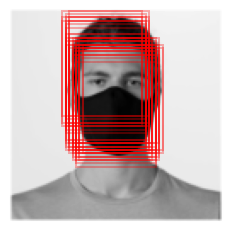

In [20]:
fig, ax = plt.subplots()
ax.imshow(im_test, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[5915,   27],
       [  50, 2655]])

In [22]:
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


bootstrap_iter = 5    # designate the number of iterations for bootstrapping

clf = SVC(C=10,kernel='rbf')    # create a SVM classifier
SV = []
accuracy = []

for i in range(bootstrap_iter):
    X_, y_ = resample(X_train, y_train)
    clf.fit(X_, y_)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_pred, y_test)
    accuracy.append(acc)
    SV.append(len(clf.support_vectors_))
    
    print(SV)

accuracy = np.array(accuracy)

print('Accuracy Score')
print('Avearge: ', accuracy.mean())
print('Standard deviation: ', accuracy.std())

[2069]
[2069, 2044]
[2069, 2044, 2008]
[2069, 2044, 2008, 2044]
[2069, 2044, 2008, 2044, 1989]
Accuracy Score
Avearge:  0.9963224239620677
Standard deviation:  0.00022424794066919337


In [23]:
accuracy

array([0.99653059, 0.99618365, 0.996068  , 0.99664624, 0.99618365])

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[5941,    1],
       [  32, 2673]])

In [25]:
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


bootstrap_iter = 5    # designate the number of iterations for bootstrapping

clf2 = LinearSVC(C=1)    # create a SVM classifier

accuracy2 = []
FP =[]
for i in range(bootstrap_iter):
    X_, y_ = resample(X_train, y_train)
    clf2.fit(X_, y_)
    y_pred2 = clf2.predict(X_test)
    
    acc = accuracy_score(y_pred2, y_test)
    accuracy2.append(acc)
    con = confusion_matrix(y_test, y_pred)
    FP.append(con[0][1])
    print(con)
    print(FP)

accuracy2 = np.array(accuracy2)

print('Accuracy Score')
print('Avearge: ', accuracy2.mean())
print('Standard deviation: ', accuracy2.std())

[[5941    1]
 [  32 2673]]
[1]
[[5941    1]
 [  32 2673]]
[1, 1]
[[5941    1]
 [  32 2673]]
[1, 1, 1]
[[5941    1]
 [  32 2673]]
[1, 1, 1, 1]
[[5941    1]
 [  32 2673]]
[1, 1, 1, 1, 1]
Accuracy Score
Avearge:  0.9895455071122934
Standard deviation:  0.0005453834218828014


In [ ]:
accuracy2

In [113]:
from PIL import Image
import numpy as np

im_test2 = np.array(Image.open('/content/images.jfif'))

print(type(im))
im_test2= color.rgb2gray(im_test2)

<class 'numpy.ndarray'>


In [114]:


im_test3 = np.array(Image.open('/content/images (3).jfif'))

print(type(im))
im_test3= color.rgb2gray(im_test3)

<class 'numpy.ndarray'>


In [115]:
im_test4 = np.array(Image.open('/content/images (2).jfif'))

print(type(im))
im_test4= color.rgb2gray(im_test4)

<class 'numpy.ndarray'>


In [176]:
im_test5 = np.array(Image.open('/content/african_child.jpg'))

print(type(im))
im_test5= color.rgb2gray(im_test5)

<class 'numpy.ndarray'>


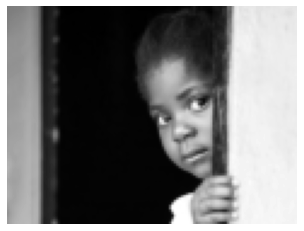

In [177]:



im_test5 = skimage.transform.rescale(im_test5, 0.2)


plt.imshow(im_test5, cmap='gray')
plt.axis('off');


In [178]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            


########################################



indices5, patches5 = zip(*sliding_window(im_test5))
patches_hog5 = np.array([feature.hog(patch) for patch in patches5])
patches_hog5.shape

(406, 1215)

In [179]:
labels = clf.predict(patches_hog5)
labels.sum()

3.0

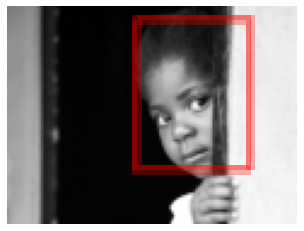

In [181]:
fig, ax = plt.subplots()
ax.imshow(im_test5, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices5 = np.array(indices5)

for i, j in indices5[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=5, facecolor='none'))